https://www.kaggle.com/code/alincijov/ssd-tf-self-driving-cars

In [1]:
# Download Kaggle data
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d alincijov/self-driving-cars

!unzip /content/self-driving-cars.zip

Streaming output truncated to the last 5000 lines.
  inflating: images/1479502279230178611.jpg  
  inflating: images/1479502279730506173.jpg  
  inflating: images/1479502280230536426.jpg  
  inflating: images/1479502280730839737.jpg  
  inflating: images/1479502281729824146.jpg  
  inflating: images/1479502282229848985.jpg  
  inflating: images/1479502282730102580.jpg  
  inflating: images/1479502283731724690.jpg  
  inflating: images/1479502284232432719.jpg  
  inflating: images/1479502285221790200.jpg  
  inflating: images/1479502285730163274.jpg  
  inflating: images/1479502286231098378.jpg  
  inflating: images/1479502287230097438.jpg  
  inflating: images/1479502287730246905.jpg  
  inflating: images/1479502288231261057.jpg  
  inflating: images/1479502288731301852.jpg  
  inflating: images/1479502289730529475.jpg  
  inflating: images/1479502290232668314.jpg  
  inflating: images/1479502291230742118.jpg  
  inflating: images/1479502292231318149.jpg  
  inflating: images/147950229

In [2]:
import os
import glob

import numpy as np
import pandas as pd
from numpy import asarray

from PIL import Image, ImageDraw
import matplotlib.pylab as plt
import cv2
from google.colab.patches import cv2_imshow

# fix random seed
np.random.seed(2023)

from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# explore data structure

In [3]:
images_dir = '/content/images/'
labels_train_path    = '/content/labels_train.csv'
labels_val_path      = '/content/labels_val.csv'
labels_trainval_path = '/content/labels_trainval.csv'

labels_train_df    = pd.read_csv(labels_train_path)
labels_val_df      = pd.read_csv(labels_val_path)
labels_trainval_df = pd.read_csv(labels_trainval_path)

labels_val_df.head(7)

,frame,xmin,xmax,ymin,ymax,class_id
0,1478899046136829030.jpg,201,206,129,135,5
1,1478899046136829030.jpg,203,210,150,158,1
2,1478899046136829030.jpg,215,219,130,135,5
3,1478899046136829030.jpg,222,234,145,162,1
4,1478899046136829030.jpg,223,235,149,160,1
5,1478899046136829030.jpg,236,262,145,168,1
6,1478899046707290405.jpg,202,207,130,136,5


In [9]:
# COUNT TOTAL IMAGES IN 'images directory'
print('total images:', len(glob.glob('/content/images/*.jpg')))

# Count total Columns (images) in each CSV
print('Total columns')
print('train.csv:'   , labels_train_df.shape[0])
print('val.csv:'     , labels_val_df.shape[0])
print('trainval.csv:', labels_trainval_df.shape[0])

# Unique filename in csv
print("Unique")
print('train.csv:',len(labels_train_df['frame'].unique()))
print('val.csv:'  ,len(labels_val_df['frame'].unique()))

total images: 22241
Total columns
train.csv: 132406
val.csv: 32699
trainval.csv: 165105
Unique
train.csv: 18000
val.csv: 4241


In [5]:
# drop filename bị trùng
train_df = labels_train_df[~labels_train_df.duplicated(subset=['frame'])]
val_df = labels_val_df[~labels_val_df.duplicated(subset=['frame'])]

train_df.shape[0], val_df.shape[0]

(18000, 4241)

In [6]:
print("class_id in csv:", val_df['class_id'].unique())

# dictionary to convert class_id to class_name (inter -> string)
classes_dict = {1:'car', 2:'truck', 3:'pedestrian', 4:'bicyclist', 5:'light'}

class_id in csv: [5 1 2 3 4]


In [57]:
def load_from_csv(df, target_size=(224,224)):
  """
  Function to take data from df
  Input:
      - dataframe
  Outputs:
      - imgs: array of all images
      - bboxs:
      - classes
  """
  imgs, classes = [],[]
  bboxs = []

  for i in range(df.shape[0]):
    img_filename = df.iloc[i, 0]
    img = cv2.imread(images_dir + img_filename)   #read
    h_o,w_o = img.shape[:2]
    h_s,w_s = target_size
    img = cv2.resize(img, target_size)            #resize
    img = np.array(img, dtype="float32") / 255.0  #norm
    imgs.append(img)

    # xmin, ymnin, xmax, ymax
    x_scale = w_s/w_o
    y_scale = h_s/h_o
    bbox = asarray([df.iloc[i,1]*x_scale/255.0,
                    df.iloc[i,3]*y_scale/255.0,
                    df.iloc[i,2]*x_scale/255.0,
                    df.iloc[i,4]*y_scale/255.0]) #resize+norm
    bboxs.append(bbox)

    class_id = df.iloc[i , 5]
    classes.append(class_id)

  return asarray(imgs), asarray(classes), asarray(bboxs, dtype=np.float32)

In [58]:
imgs_train, classes_train, bboxs_train = load_from_csv(train_df[:200])
imgs_val  , classes_val  , bboxs_val   = load_from_csv(val_df[:50])
bboxs_val

array([[0.36784315, 0.37772548, 0.37699348, 0.39529413],
       [0.3696732 , 0.3806536 , 0.37882352, 0.3982222 ],
       [0.17019607, 0.45971242, 0.1903268 , 0.47728103],
       [0.09333333, 0.42750326, 0.15921569, 0.47435296],
       [0.02196078, 0.48313725, 0.07686274, 0.5094902 ],
       [0.00366013, 0.43335947, 0.11895425, 0.48020914],
       [0.        , 0.41871896, 0.09333333, 0.46264052],
       [0.        , 0.40993464, 0.05856209, 0.4538562 ],
       [0.02196078, 0.4567843 , 0.05490196, 0.48313725],
       [0.2379085 , 0.41579086, 0.26352942, 0.4538562 ],
       [0.18666667, 0.41871896, 0.2214379 , 0.46849674],
       [0.3330719 , 0.15811765, 0.3532026 , 0.22839215],
       [0.4062745 , 0.3835817 , 0.4227451 , 0.40407842],
       [0.23607843, 0.39529413, 0.25986928, 0.42457515],
       [0.20862745, 0.40115032, 0.23973857, 0.43628758],
       [0.17568627, 0.40993464, 0.20679739, 0.4450719 ],
       [0.12444445, 0.42457515, 0.15555556, 0.45971242],
       [0.18117647, 0.4392157 ,

# Prepare data for modeling

In [59]:
print(classes_train.shape)

# perform one-hot encoding on the labels
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
classes_train = lb.fit_transform(classes_train)
classes_val   = lb.fit_transform(classes_val)

print(classes_train.shape)

(200,)
(200, 5)


In [60]:
# Construct dict for targets outputs

targets_train = {"class_label" : classes_train,
                "bounding_box": bboxs_train}

targets_test = {"class_label" : classes_val,
               "bounding_box": bboxs_val}

# visulazie data

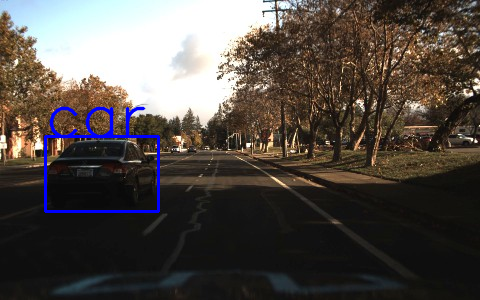

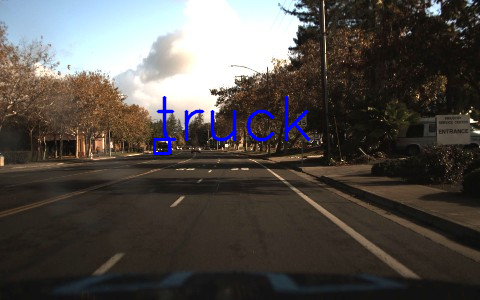

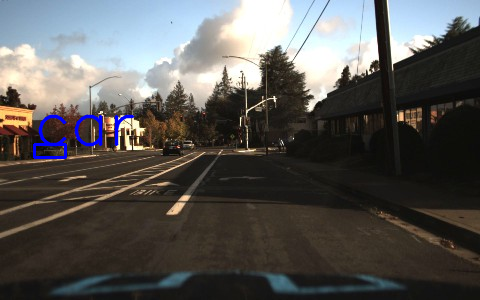

In [7]:
def plot_bbox(id, df):
  img   = cv2.imread(images_dir + df.iloc[id, 0])
  label = df.iloc[id, 5]
  bbox  = df.iloc[id, [1,3,2,4]].values
  # draw bbox
  img = cv2.rectangle(img, bbox[:2], bbox[-2:], (255,0,0), 2)
  # class text
  img = cv2.putText(img, classes_dict[label], bbox[:2], cv2.FONT_HERSHEY_SIMPLEX,
                   2, (255,0,0), 2, cv2.LINE_AA)
  cv2_imshow(img)

plot_bbox(id=15, df=train_df)
plot_bbox(id=5, df=train_df)
plot_bbox(id=40, df=train_df)

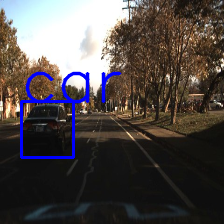

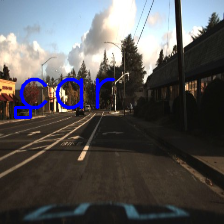

In [21]:
def plot_rescaled_bbox(id, df, target_size=(224,224)):
  img   = cv2.imread(images_dir + df.iloc[id, 0])
  h_o,w_o  = img.shape[:2]
  h_s,w_s  =  target_size
  img   = cv2.resize(img, target_size)

  # draw bbox
  x_scale = w_s/w_o
  y_scale = h_s/h_o
  bbox  = asarray([df.iloc[id,1]*x_scale, df.iloc[id,3]*y_scale,
                   df.iloc[id,2]*x_scale, df.iloc[id,4]*y_scale]) #norm
  img = cv2.rectangle(img, (int(bbox[0]),int(bbox[1])),
                           (int(bbox[2]),int(bbox[3])), (255,0,0), 2)
  # class text
  label = df.iloc[id, 5]
  img = cv2.putText(img, classes_dict[label],
                    (int(bbox[0]),int(bbox[1])), cv2.FONT_HERSHEY_SIMPLEX,
                   2, (255,0,0), 2, cv2.LINE_AA)
  cv2_imshow(img)

plot_rescaled_bbox(id=15, df=train_df)
plot_rescaled_bbox(id=40, df=train_df)

# heper function
loss- bounding_box_loss - class_label_loss - bounding_box_accuracy - class_label_accuracy

In [72]:
def plot_acc_loss(H):
  """
  Function to plot 2 curves (loss and acc of classes and bboxes)
  """
  lossNames = ["loss", "class_label_loss", "bounding_box_loss"]
  accuracyNames = ['bounding_box_accuracy', 'class_label_accuracy']

  class_loss = H.history["class_label_loss"]
  bbox_loss  = H.history["bounding_box_loss"]

  class_acc = H.history['class_label_accuracy']
  bbox_acc  = H.history['bounding_box_accuracy']

  # plot
  epochs = range(len(class_acc))
  plt.plot(epochs, class_acc ,'b',label='class acc')
  plt.plot(epochs, bbox_acc  ,'r',label='bbox acc')
  plt.legend(); plt.figure()
  plt.plot(epochs, class_loss,'b-',label='class loss')
  plt.plot(epochs, bbox_loss ,'r-',label='bbox loss')
  plt.legend(); plt.figure()

# model

In [29]:
n_classes = 5

In [66]:
# load the VGG16 network, ensuring the head FC layers are left off
vgg = VGG16(weights="imagenet", include_top=False,
            input_tensor=Input(shape=(224, 224, 3)))

# freeze all VGG layers so they will *not* be updated during the
# training process
vgg.trainable = False

# flatten the max-pooling output of VGG
flatten = vgg.output
flatten = Flatten()(flatten)

# BBox head
bboxHead = Dense(128, activation="LeakyReLU")(flatten)
bboxHead = Dropout(0.5)(bboxHead)
bboxHead = Dense(64,  activation="LeakyReLU")(bboxHead)
bboxHead = Dropout(0.5)(bboxHead)
bboxHead = Dense(32,  activation="LeakyReLU")(bboxHead)
bboxHead = Dropout(0.5)(bboxHead)
bboxHead = Dense(4,   activation="softmax",
                 name="bounding_box")(bboxHead)

# Classification Head
softmaxHead = Dense(512, activation="LeakyReLU")(flatten)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(128, activation="LeakyReLU")(softmaxHead)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(64,  activation="LeakyReLU")(softmaxHead)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(5,   activation="softmax",
                         name="class_label")(softmaxHead)

# put together our model which accept an input image and then output
# bounding box coordinates and a class label
model = Model(inputs=vgg.input,
              outputs=(bboxHead, softmaxHead)
               )

In [67]:
learning_rate = 0.01
opt = Adam(learning_rate=learning_rate)

# Dictionary of loss methods for each head
losses = {  "class_label"  : "categorical_crossentropy",
            "bounding_box" : "mean_squared_error",
          }

# Dictionary specifies weights/ loss
lossWeights = { "class_label"  : 1.0,
                "bounding_box" : 1.0}

model.compile(loss=losses,
              optimizer=opt,
              metrics=["accuracy"],
              loss_weights=lossWeights)

In [68]:
H = model.fit(
	imgs_train, targets_train,
	#validation_data=(testImages, testTargets),
	batch_size = 64,
	epochs = 30,
	verbose = 1)

Epoch 1/30
4/4 [==============================] - 4s 188ms/step - loss: 71.4684 - bounding_box_loss: 0.1454 - class_label_loss: 71.3230 - bounding_box_accuracy: 0.3550 - class_label_accuracy: 0.3350
Epoch 2/30
4/4 [==============================] - 1s 194ms/step - loss: 99.6308 - bounding_box_loss: 0.1829 - class_label_loss: 99.4479 - bounding_box_accuracy: 0.2950 - class_label_accuracy: 0.6000
Epoch 3/30
4/4 [==============================] - 1s 184ms/step - loss: 63.7969 - bounding_box_loss: 0.1772 - class_label_loss: 63.6196 - bounding_box_accuracy: 0.1450 - class_label_accuracy: 0.6750
Epoch 4/30
4/4 [==============================] - 1s 187ms/step - loss: 71.1607 - bounding_box_loss: 0.1821 - class_label_loss: 70.9785 - bounding_box_accuracy: 0.0750 - class_label_accuracy: 0.4850
Epoch 5/30
4/4 [==============================] - 1s 185ms/step - loss: 43.0803 - bounding_box_loss: 0.1814 - class_label_loss: 42.8989 - bounding_box_accuracy: 0.0500 - class_label_accuracy: 0.6650
Epoch

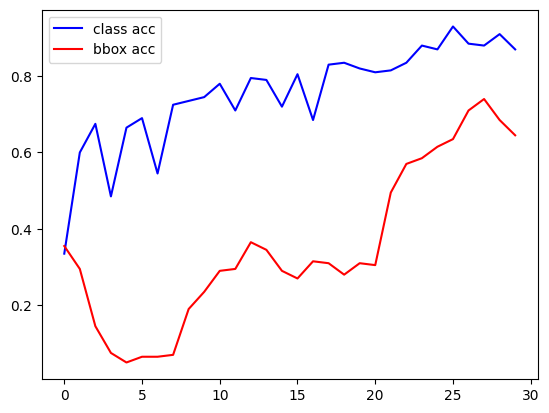

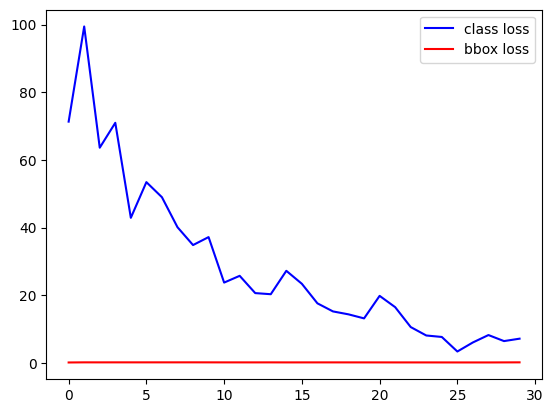

<Figure size 640x480 with 0 Axes>

In [73]:
plot_acc_loss(H)